In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [14]:
IMAGE_SIZE=256 #pixels
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  # give root directory name
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 2164 files belonging to 4 classes.


2023-03-18 19:43:19.801375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-03-18 19:43:19.801427: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
class_names=dataset.class_names
print(class_names, len(dataset))
# 68 because batch of 32 for total 68 in no.
# use len() in place of shape
print(dataset)

['.ipynb_checkpoints', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'] 68
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
for es, ts in dataset.take(1):
    print(es.shape,ts.shape)
    print(ts.numpy()) # ts in tensor initially
    print(es[0])

(32, 256, 256, 3) (32,)
[1 1 1 1 1 2 1 1 1 2 1 2 2 1 2 1 2 2 1 1 1 2 2 2 2 1 1 3 1 1 1 1]
tf.Tensor(
[[[207. 199. 197.]
  [194. 186. 184.]
  [191. 183. 181.]
  ...
  [200. 195. 192.]
  [202. 197. 194.]
  [209. 204. 201.]]

 [[201. 193. 191.]
  [192. 184. 182.]
  [190. 182. 180.]
  ...
  [200. 195. 192.]
  [201. 196. 193.]
  [206. 201. 198.]]

 [[195. 187. 185.]
  [189. 181. 179.]
  [189. 181. 179.]
  ...
  [201. 196. 193.]
  [200. 195. 192.]
  [203. 198. 195.]]

 ...

 [[142. 134. 132.]
  [142. 134. 132.]
  [145. 137. 135.]
  ...
  [137. 129. 127.]
  [143. 135. 133.]
  [148. 140. 138.]]

 [[141. 133. 131.]
  [139. 131. 129.]
  [140. 132. 130.]
  ...
  [138. 130. 128.]
  [144. 136. 134.]
  [149. 141. 139.]]

 [[135. 127. 125.]
  [132. 124. 122.]
  [131. 123. 121.]
  ...
  [141. 133. 131.]
  [146. 138. 136.]
  [150. 142. 140.]]], shape=(256, 256, 3), dtype=float32)


2023-03-18 19:43:20.814705: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


2023-03-18 19:43:21.565792: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


only one print hence outer loop is one step process


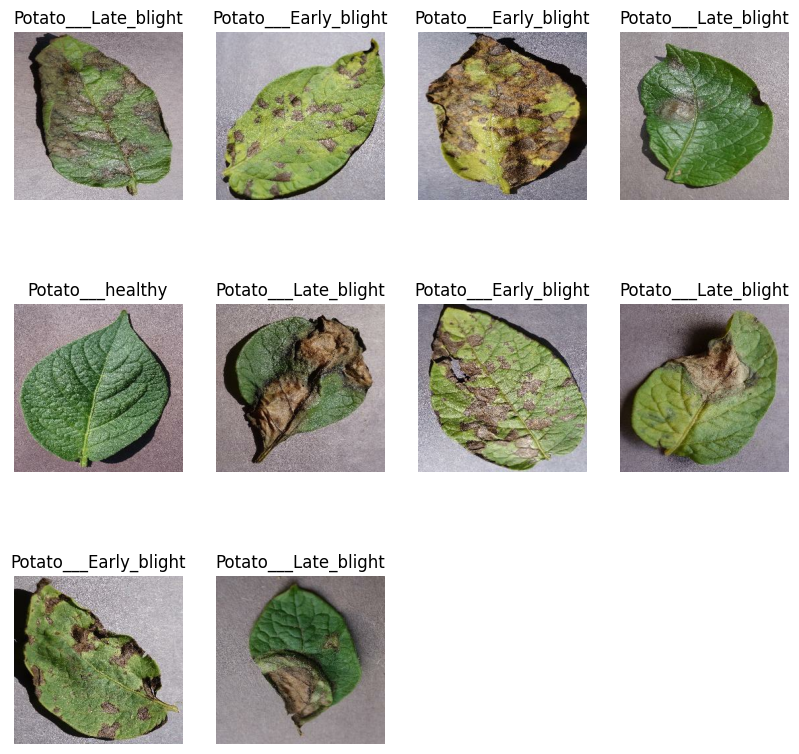

In [6]:
## 1,2,3 are classes
## es[0] is one image data 256x256x3
plt.figure(figsize=(10,10))
for img,label in dataset.take(1): ## img mapped to 32 img, label in one step only no loop again and again
    for i in range(10):# select ith from that 32 label
        ax=plt.subplot(3,4,i+1) ## i tell position 3,4 rows and columns
        ## plt.imshow(es[1].numpy()) give raw unbalancedcolours 
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        #print(img[0][0].numpy().astype("uint8"))   ### 256x3 shape
        plt.axis("off")
    print("only one print hence outer loop is one step process")

In [7]:
## 80% , 10% , 10% splitting.........................................................
dataset=dataset.shuffle(1000,seed=12)
train_ds=dataset.take(int(len(dataset)*0.8))   ## [0:54]
test=dataset.skip(int(len(dataset)*0.8))    ## [54:end]
cv_ds=test.take(int(len(test)*0.5))    ## [0:mid]
test_ds=test.skip(int(len(test)*0.5))    ## [mid:end]
print(len(train_ds),len(test),len(cv_ds),len(test_ds))

54 14 7 7


In [8]:
# ----------train_ds.cache()------------ ### read data from disk and kepp in memory so make process fast for next iteration [[[don't read same image again and again]]]
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)   ## prefetch load next batch if cpu/gpu busy in training in old batch
cv_ds=cv_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)   ## prefetch load next batch if cpu/gpu busy in training in old batch
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)   ## prefetch load next batch if cpu/gpu busy in training in old batch

In [9]:
### now training will run fast
resize_and_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
## both made above are layers we will use furthur
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

In [17]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=3,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=cv_ds
)
    

Epoch 1/50
